###Proyecto Parte 2: Deployment, Inferencia y Predicción

In [1]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import pandas as pd 


In [59]:
from sklearn import tree
import graphviz
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn import svm
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

In [2]:
import joblib

In [109]:
#Naive Bayes
def cal_p_survived(df,passSurvived):  #funcion para calcular la probabilidad de sobrevivir o no sobrevivir 'passenger_survived'
  p_survived = df.groupby(passSurvived).size().div(len(df)) 
  return p_survived

def calc_p_features(df,prb_survived):  #funcion para calcular las probabilidades de cada caracteristica dado 'passenger_survived'
  p_features_survived = {}
  p_features_survived['Age'] = df.groupby(['passenger_survived', 'Age']).size().div(len(df)).div(prb_survived)
  p_features_survived['SibSp'] = df.groupby(['passenger_survived', 'SibSp']).size().div(len(df)).div(prb_survived)
  p_features_survived['Parch'] = df.groupby(['passenger_survived', 'Parch']).size().div(len(df)).div(prb_survived)
  p_features_survived['Fare'] = df.groupby(['passenger_survived', 'Fare']).size().div(len(df)).div(prb_survived)
  p_features_survived['Embarked'] = df.groupby(['passenger_survived', 'Embarked']).size().div(len(df)).div(prb_survived)
  p_features_survived['passenger_class'] = df.groupby(['passenger_survived', 'passenger_class']).size().div(len(df)).div(prb_survived)
  p_features_survived['passenger_sex'] = df.groupby(['passenger_survived', 'passenger_sex']).size().div(len(df)).div(prb_survived)
  return p_features_survived

#Funcion para calcular la probabilidad de sobrevivir (1) o de no sobrevivir(0)
def calc_Y_prob(age,sibsp,parch,fare,embarked,passClass,passSex,p_feature_survive,p_survive):
  try:
    p_yes = p_feature_survive["Age"][1][age] * p_feature_survive['SibSp'][1][sibsp] * \
        p_feature_survive['Parch'][1][parch] * p_feature_survive['Fare'][1][fare] \
        *p_feature_survive['Embarked'][1][embarked]*p_feature_survive['passenger_class'][1][passClass] \
        *p_feature_survive['passenger_sex'][1][passSex] \
        * p_survive[1]
  except:
    p_yes = 0

  try: 
    p_no = p_feature_survive["Age"][0][age] * p_feature_survive['SibSp'][0][sibsp] * \
        p_feature_survive['Parch'][0][parch] * p_feature_survive['Fare'][0][fare] \
        *p_feature_survive['Embarked'][0][embarked]*p_feature_survive['passenger_class'][0][passClass] \
        *p_feature_survive['passenger_sex'][0][passSex] \
        * p_survive[0]
  except:
    p_no = 0
    
  return p_yes/(p_yes+p_no)

def bayes_model(dataset):
  df_data = dataset
 
  ##'Age','SibSp','Parch','Fare','Embarked','passenger_class','passenger_sex'
  y_hat = []
  prb_passenger_survived = cal_p_survived(df_data,'passenger_survived')
  prb_features = calc_p_features(df_data,prb_passenger_survived)

  for index, row in df_data.iterrows():
    y_hat=np.append(y_hat,calc_Y_prob(row['Age'], row['SibSp'], row['Parch'], row['Fare'], row['Embarked'],
                             row['passenger_class'], row['passenger_sex'],prb_features,prb_passenger_survived))
  
  y_hat = np.where(np.array(y_hat) < 0.5, 0, 1)
  #print(y_hat)
  #experimento("NaiveBayes",dataset["passenger_survived"],y_hat)
  return y_hat



In [108]:
#Regresion Logistica
def pred_RegLogBinaria(x,parametros): #Funcion para encontrar y_hat con el modelo elegido
  x_temp= x.copy()
  x_temp.insert(0,"unos",1,allow_duplicates=False)
  x_temp = tf.constant(x_temp.to_numpy().tolist(), name="x_ones")
  y_hat = tf.nn.sigmoid(tf.matmul(x_temp, tf.transpose(parametros)))
  y_hat = tf.reshape(y_hat, [-1])
  predictions = np.where(np.array(y_hat) < 0.5, 0, 1)

  return predictions


In [3]:
DecisionTree_Model = joblib.load('DecisionTreeModel.pkl')
SVM_Model = joblib.load('SVM_Model.pkl')

In [ ]:
param_RegLMod = np.loadtxt('RegresionL_Model.txt')
param_RegLMod

In [138]:
data_test = pd.read_csv('DataLista.csv')


In [14]:
#Data del set de datos para tomar 10 random
X = data_test[['Age','SibSp','Parch','Fare','Embarked','passenger_class','passenger_sex']]
Y = data_test[['passenger_survived']]
X.iloc[0:1,:]

,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex
0,22.0,1,0,7.25,2,0,1


In [124]:
def ensemble_models(x,modelo1, modelo2, modelo3, modelo4):
  decisionTree_pred = modelo1.predict(x.iloc[0:1,0:7])
  SVM_pred = modelo2.predict(x.iloc[0:1,:7])
  temp_bayes = x.copy()
  temp_bayes["passenger_survived"] = Y["passenger_survived"]
  temp_bayes.iloc[0:1,:]
  bayes_pred = bayes_model(temp_bayes.iloc[0:1,:])
  parametros_tf = tf.constant(modelo4, name="parametros", dtype=tf.float32)
  parametros_tf=tf.reshape(parametros_tf, (1,8))
  RegLB_pred = pred_RegLogBinaria(X.iloc[0:1,0:7],parametros_tf)

  y_hat = pd.DataFrame(np.column_stack((decisionTree_pred,SVM_pred,bayes_pred,RegLB_pred)))
  y_hat = pd.DataFrame(y_hat.mode(axis=1)[0]).astype(int)
  y_hat.columns = ['passenger_survived']
  #y_hat
  print('Predicción ensemble models: ',y_hat.iloc[0].to_numpy())
  print('Predicción Naive Bayes   : ',bayes_pred)
  print('Predicción Reg Logistica : ',RegLB_pred)

  feature_names = ['Age','SibSp','Parch','Fare','Embarked','passenger_class','passenger_sex']
  y_class = np.array(['0','1'])
  dot_data = export_graphviz(DecisionTree_Model,feature_names=feature_names,class_names=y_class,
                             filled=True,rounded=True,special_characters=True)
  return graphviz.Source(dot_data)
  

Predicción ensemble models:  [0]
Predicción Naive Bayes   :  [0]
Predicción Reg Logistica :  [0]


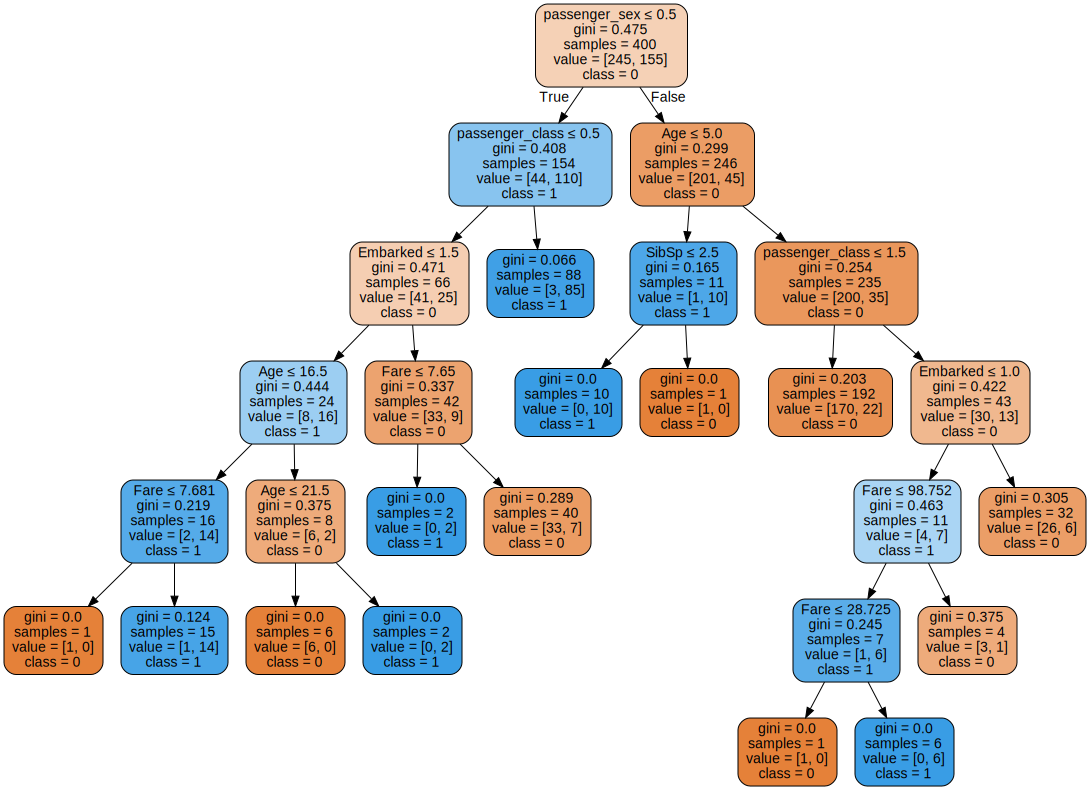

In [125]:
ensemble_models(X.iloc[0:1,:],DecisionTree_Model, SVM_Model, 'Bayes', param_RegLMod)


Predicción ensemble models:  [1]
Predicción Naive Bayes   :  [1]
Predicción Reg Logistica :  [0]


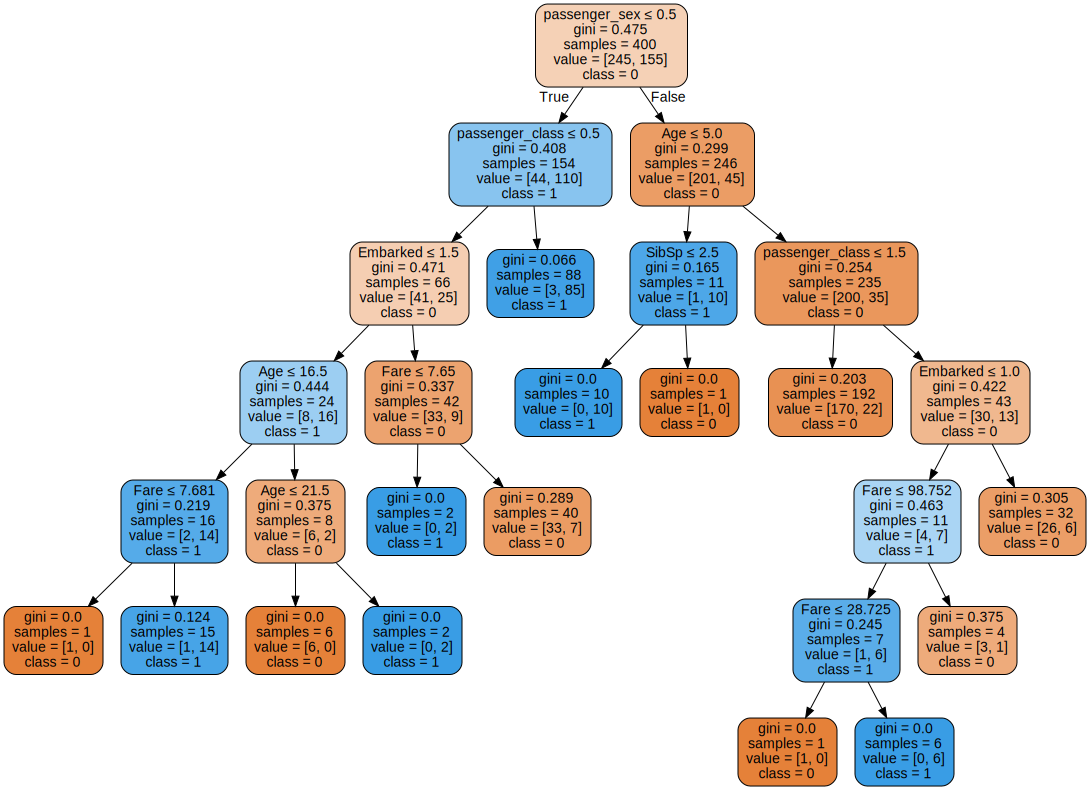

In [129]:
ensemble_models(X.iloc[3:4,:],DecisionTree_Model, SVM_Model, 'Bayes', param_RegLMod)

Predicción ensemble models:  [0]
Predicción Naive Bayes   :  [1]
Predicción Reg Logistica :  [0]


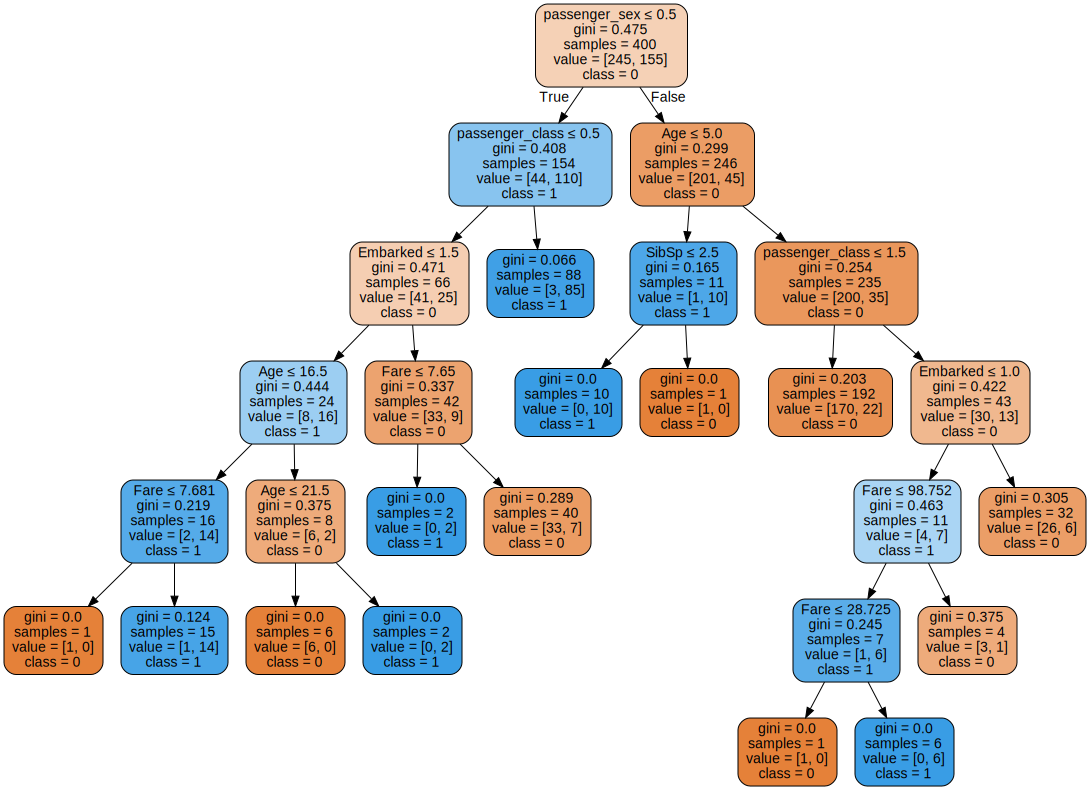

In [130]:
ensemble_models(X.iloc[10:11,:],DecisionTree_Model, SVM_Model, 'Bayes', param_RegLMod)

Predicción ensemble models:  [0]
Predicción Naive Bayes   :  [0]
Predicción Reg Logistica :  [0]


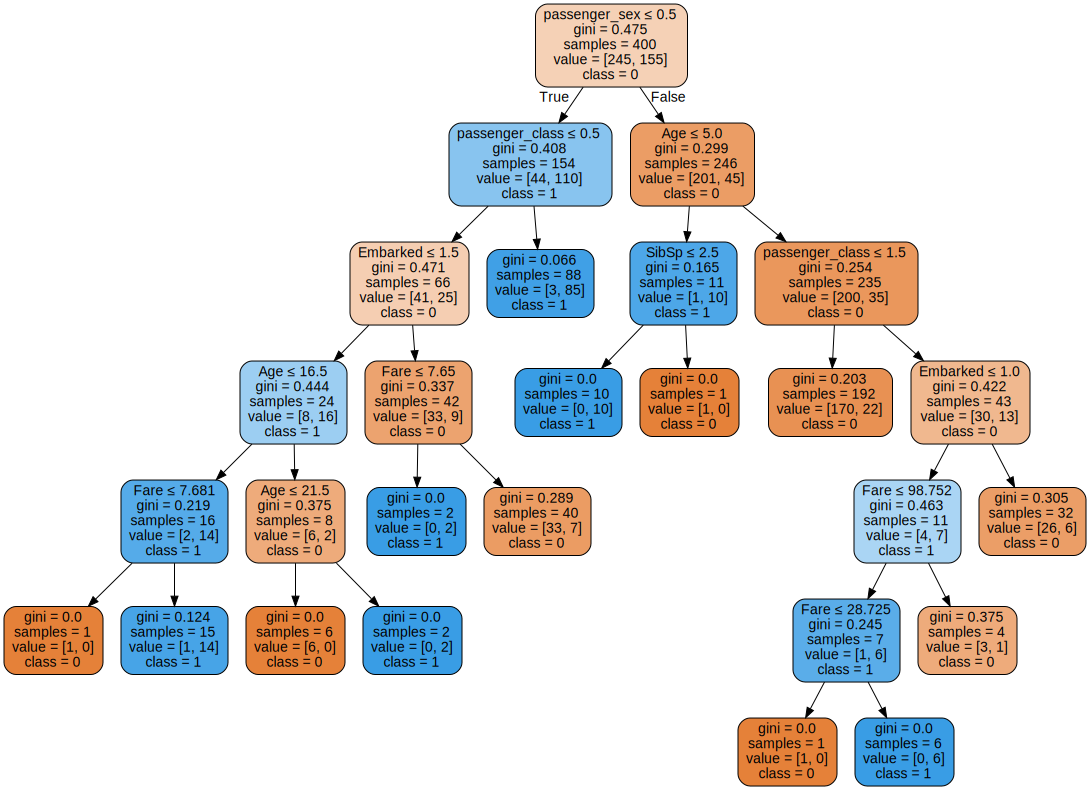

In [131]:
ensemble_models(X.iloc[30:31,:],DecisionTree_Model, SVM_Model, 'Bayes', param_RegLMod)

Predicción ensemble models:  [0]
Predicción Naive Bayes   :  [0]
Predicción Reg Logistica :  [0]


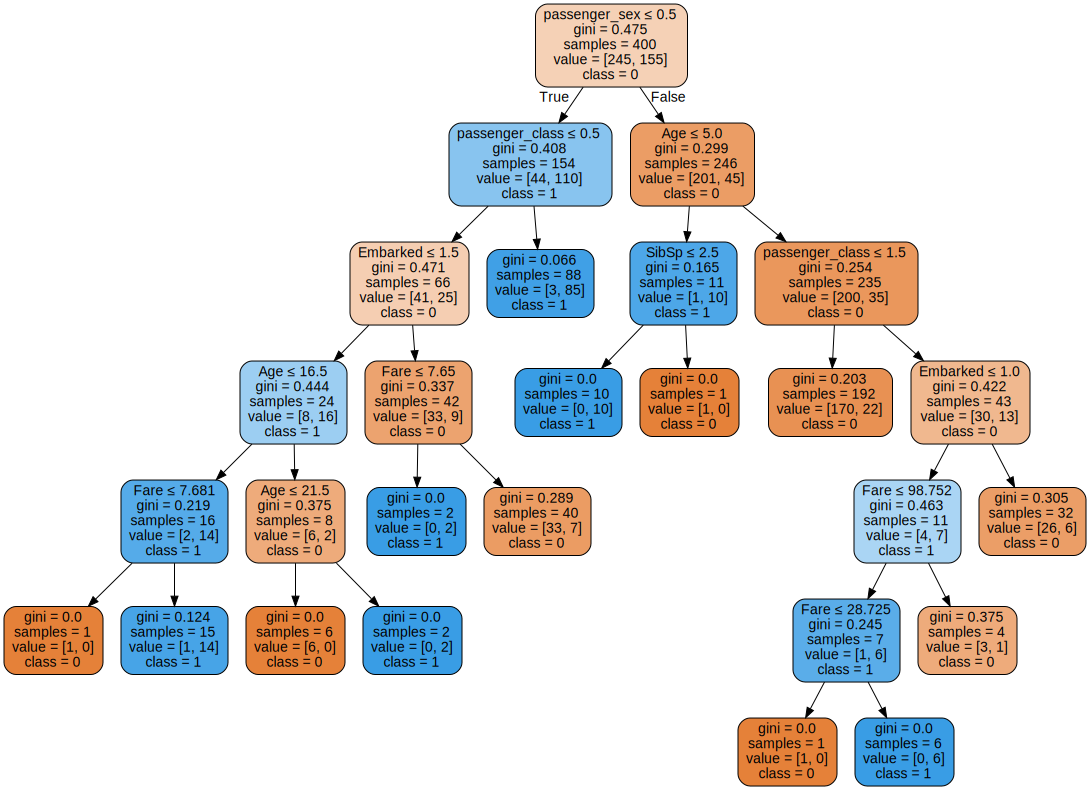

In [132]:
ensemble_models(X.iloc[250:251,:],DecisionTree_Model, SVM_Model, 'Bayes', param_RegLMod)

Predicción ensemble models:  [0]
Predicción Naive Bayes   :  [0]
Predicción Reg Logistica :  [0]


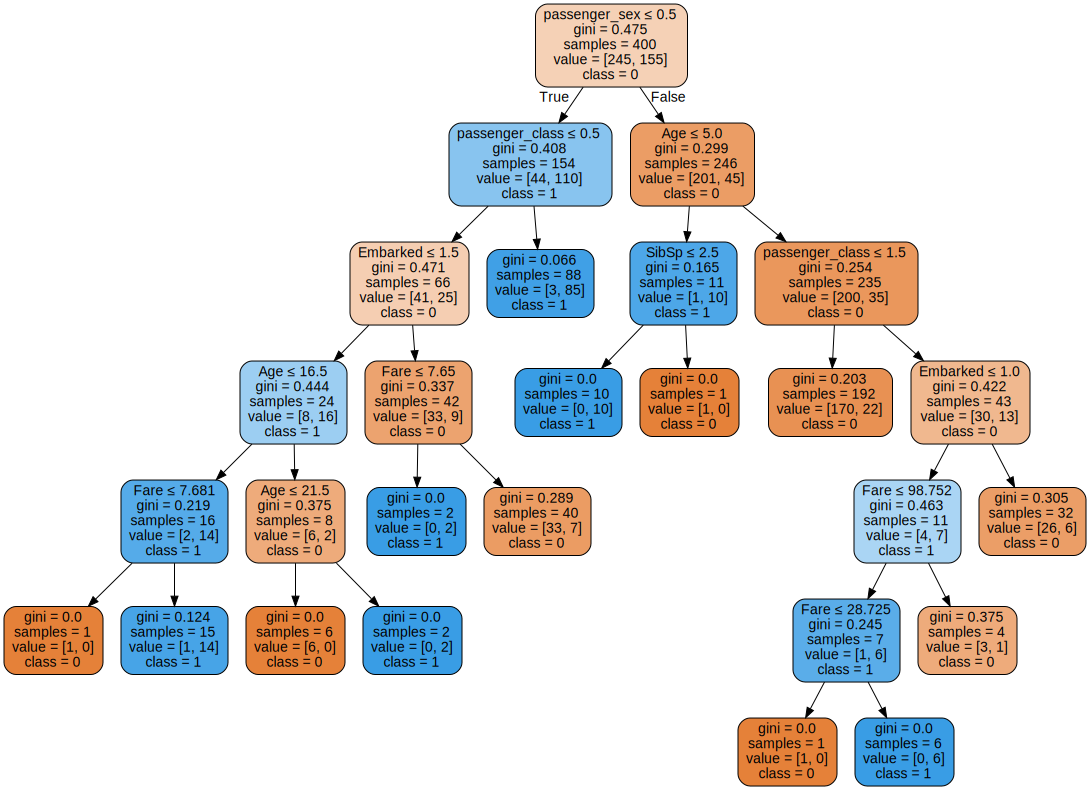

In [133]:
ensemble_models(X.iloc[14:15,:],DecisionTree_Model, SVM_Model, 'Bayes', param_RegLMod)

Predicción ensemble models:  [0]
Predicción Naive Bayes   :  [0]
Predicción Reg Logistica :  [0]


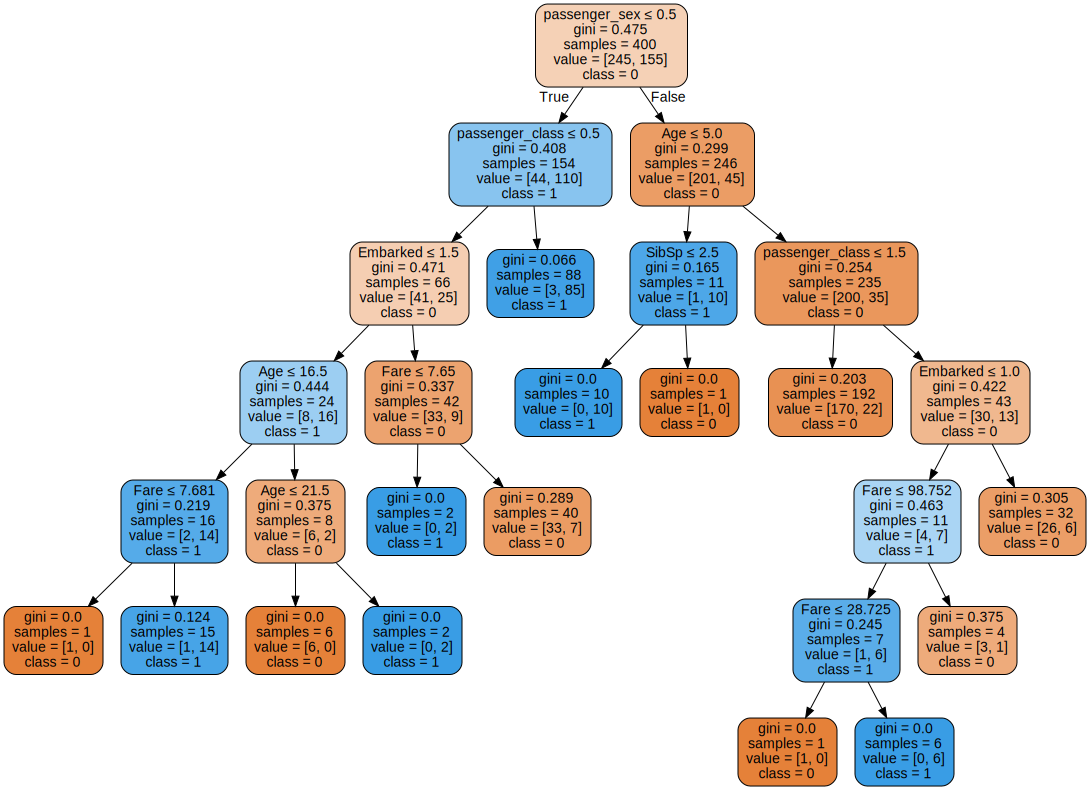

In [134]:
ensemble_models(X.iloc[35:36,:],DecisionTree_Model, SVM_Model, 'Bayes', param_RegLMod)

Predicción ensemble models:  [0]
Predicción Naive Bayes   :  [0]
Predicción Reg Logistica :  [0]


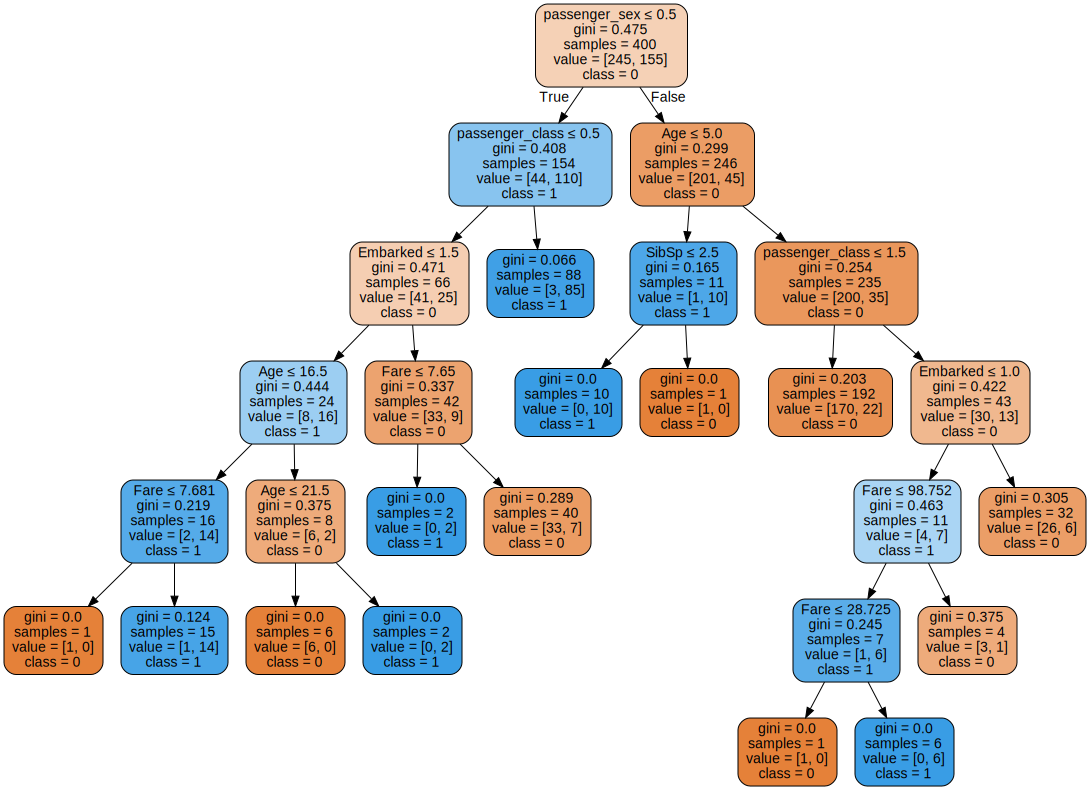

In [135]:
ensemble_models(X.iloc[18:19,:],DecisionTree_Model, SVM_Model, 'Bayes', param_RegLMod)

Predicción ensemble models:  [0]
Predicción Naive Bayes   :  [0]
Predicción Reg Logistica :  [0]


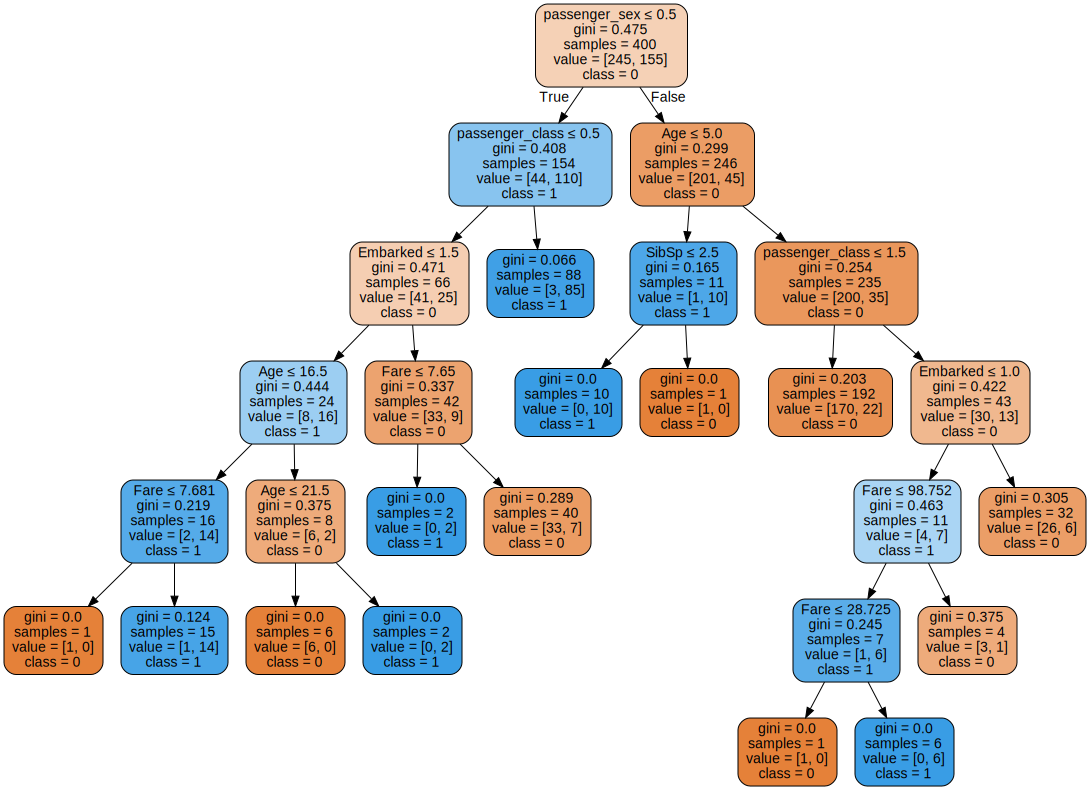

In [136]:
ensemble_models(X.iloc[150:151,:],DecisionTree_Model, SVM_Model, 'Bayes', param_RegLMod)

Predicción ensemble models:  [1]
Predicción Naive Bayes   :  [1]
Predicción Reg Logistica :  [0]


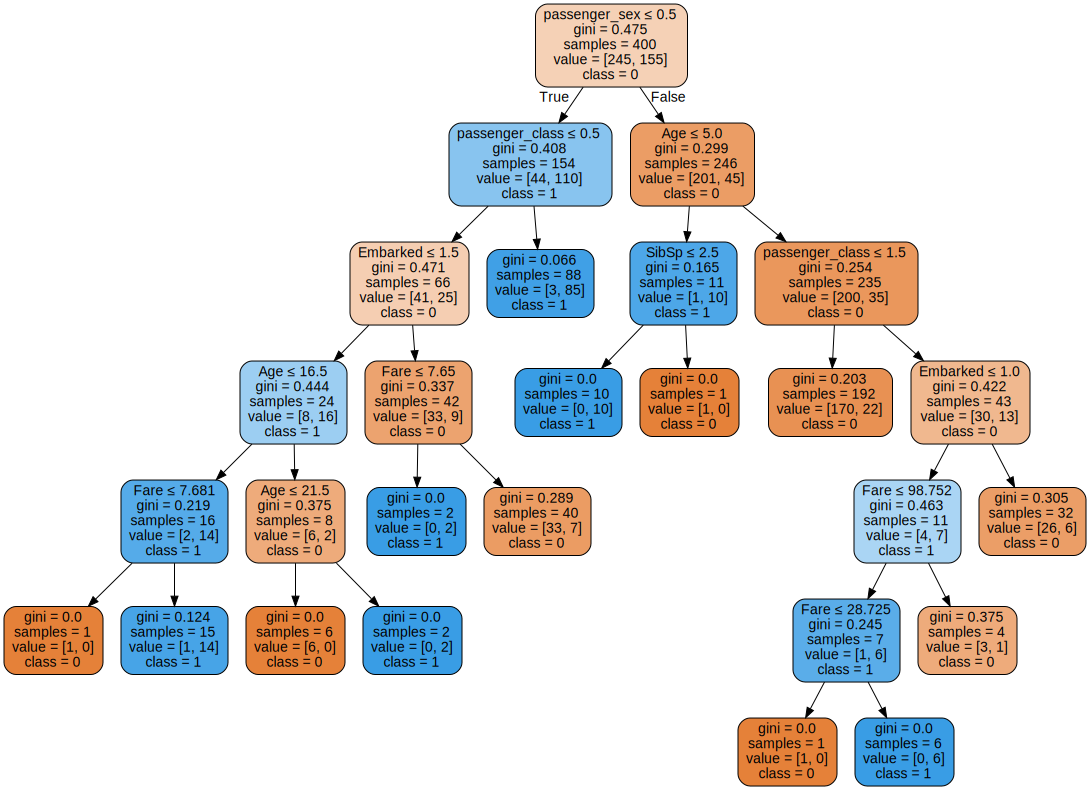

In [137]:
ensemble_models(X.iloc[300:301,:],DecisionTree_Model, SVM_Model, 'Bayes', param_RegLMod)